In [1]:
from nilearn import plotting, datasets
from nilearn import surface
from utils import RESULTS_DIR
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Circle
from matplotlib.colors import ListedColormap

import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img
from nilearn.datasets import fetch_atlas_destrieux_2009

import os
import numpy as np
import seaborn as sns

from utils import TWO_STAGE_GLM_DATA_DIR, ROOT_DIR
from analyses.ridge_regression_decoding import get_functional_mask, get_anatomical_mask, REGIONS_HIGH_LEVEL_VISUAL, REGIONS_LANGUAGE, REGIONS_LOW_LEVEL_VISUAL, MASK_FUNCTIONAL_LANGUAGE, MASK_FUNCTIONAL_VISUAL1, MASK_FUNCTIONAL_VISUAL2, MASK_ANATOMICAL_LANGUAGE

sns.set(font_scale=1.0)
MASK_PALETTE = sns.color_palette('Set2')[3:3+4][::-1][1:]

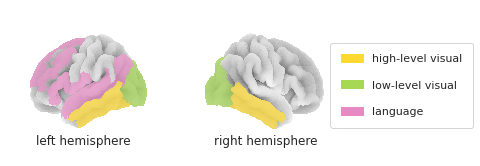

In [17]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
labels = destrieux_atlas['labels']
fsaverage = datasets.fetch_surf_fsaverage()

fig, axes = plt.subplots(1, 2, figsize=(6, 4), subplot_kw={'projection': '3d'})

for axis, hem_short, hem in zip(axes, ['L', 'R'], ['left', 'right']):
    parcellation = destrieux_atlas[f'map_{hem}']

    regions_compatible_lang = [str.encode(r[2:]) for r in REGIONS_LANGUAGE if r.startswith(hem_short)]
    pcc_regions_indices_lang = [labels.index(r) for r in regions_compatible_lang]
    pcc_labels_lang = [np.where(parcellation == index)[0] for index in pcc_regions_indices_lang]
    pcc_labels_lang = np.concatenate(pcc_labels_lang) if len(pcc_labels_lang) > 0 else []
    
    regions_compatible_vision_low = [str.encode(r[2:]) for r in REGIONS_LOW_LEVEL_VISUAL if r.startswith(hem_short)]
    pcc_regions_indices_vision_low = [labels.index(r) for r in regions_compatible_vision_low]
    pcc_labels_vision_low = np.concatenate([np.where(parcellation == index)[0] for index in pcc_regions_indices_vision_low])
    
    regions_compatible_vision_high = [str.encode(r[2:]) for r in REGIONS_HIGH_LEVEL_VISUAL if r.startswith(hem_short)]
    pcc_regions_indices_vision_high = [labels.index(r) for r in regions_compatible_vision_high]
    pcc_labels_vision_high = np.concatenate([np.where(parcellation == index)[0] for index in pcc_regions_indices_vision_high])
    
    # Transform ROI indices in ROI map
    roi_map = np.zeros(parcellation.shape[0], dtype=int)
    roi_map[pcc_labels_vision_high] = 1
    roi_map[pcc_labels_vision_low] = 2
    roi_map[pcc_labels_lang] = 3

    cmap = ListedColormap(MASK_PALETTE) if hem == 'left' else ListedColormap(MASK_PALETTE[:2])
    plotting.plot_surf_roi(
        fsaverage[f'pial_{hem}'],
        roi_map=roi_map,
        hemi=hem,
        view='lateral', #anterior #[270.0, 90.0]
        bg_map=fsaverage[f'sulc_{hem}'],
        bg_on_data=True,
        cmap=cmap,
        title=f'{hem}',
        axes=axis,
        # alpha=0.5,
    )
    
names = ["high-level visual", "low-level visual", "language"]
# legend_elements = [Line2D([0], [0], marker='o', color='g', label=label, markerfacecolor=color, markersize=20) for color, label in zip(MASK_PALETTE, names)]
legend_elements = [Circle((0, 0), radius=5, color=color, label=label) for color, label in zip(MASK_PALETTE, names)]
axes[0].set_title('left hemisphere', pad=0, y=0.1)
axes[-1].set_title('right hemisphere', pad=0, y=0.1)
axes[0].set_facecolor('w')
axes[-1].set_facecolor('w')

lgd = axes[-1].legend(handles=legend_elements, labelspacing = 1.5, borderpad=1, bbox_to_anchor=(1.9, 0.8), facecolor='w') #
# plt.subplots_adjust(hspace=0, bottom=0)
# plt.tight_layout(pad=-100)
# fig.set_size_inches(18.5, 8, forward=True)
plt.savefig(os.path.join(RESULTS_DIR, f"roi_masks.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/nilearn/datasets/atlas.py:354: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/nilearn/datasets/atlas.py:354: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


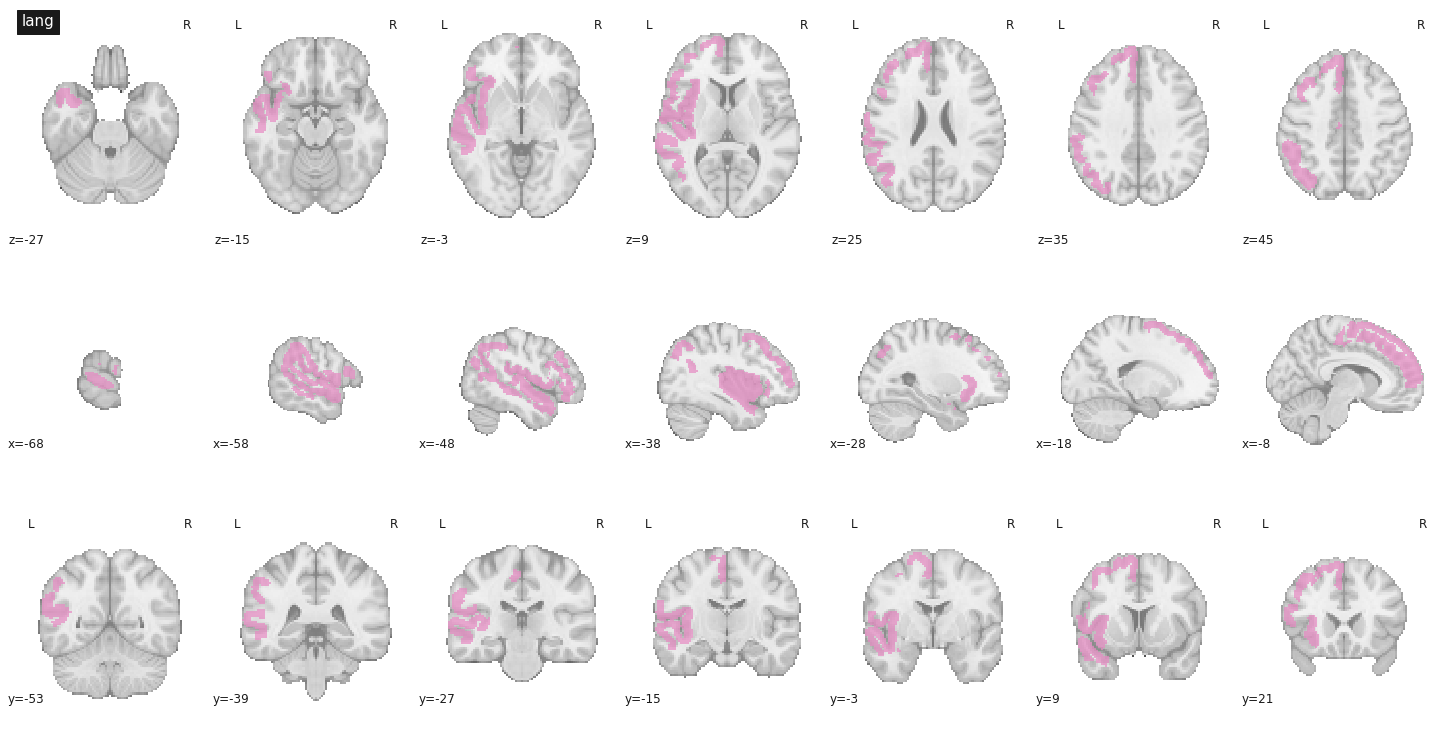

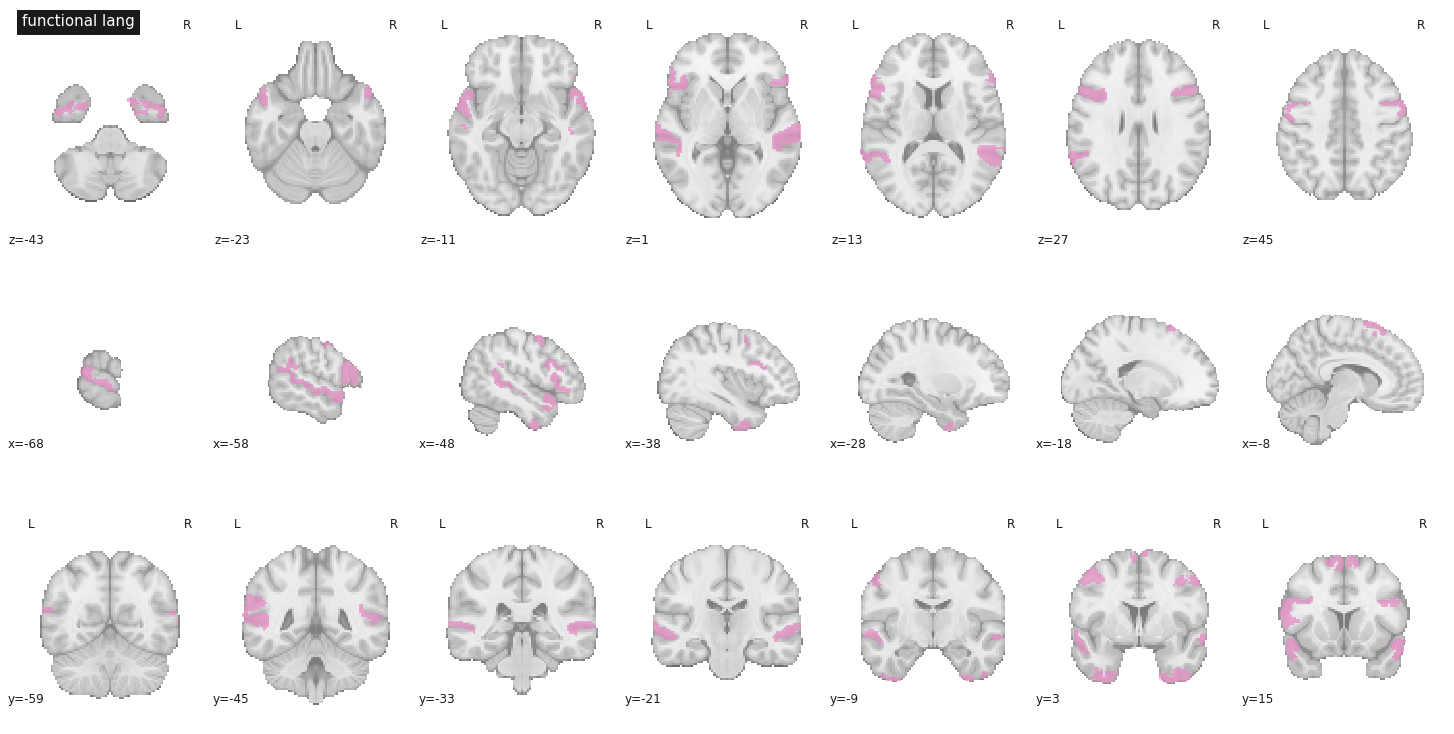

In [3]:
SUBJECT = "sub-01"
fmri_data_dir = os.path.join(TWO_STAGE_GLM_DATA_DIR, SUBJECT)
gray_matter_mask_address = os.path.join(fmri_data_dir, f'unstructured', 'mask.nii')
gray_matter_mask_img = nib.load(gray_matter_mask_address)
gray_matter_mask_ras = nib.as_closest_canonical(gray_matter_mask_img)
cmap = ListedColormap(MASK_PALETTE[2:])

destrieux_atlas = fetch_atlas_destrieux_2009()
label_to_id_dict = {label[1]: int(label[0]) for label in destrieux_atlas['labels']}
atlas_map = nib.load(destrieux_atlas.maps).get_fdata()
                      
mask = get_anatomical_mask(MASK_ANATOMICAL_LANGUAGE)
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plt.figure(figsize=(20,10))
fig = plotting.plot_roi(test_mask_img, title="lang", figure=fig, display_mode='mosaic', cmap=cmap)

mask = get_functional_mask(MASK_FUNCTIONAL_LANGUAGE, gray_matter_mask_ras)
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plt.figure(figsize=(20,10))
fig = plotting.plot_roi(test_mask_img, title="functional lang", display_mode='mosaic', figure=fig, cmap=cmap) #cut_coords=(-57, -24, 2)


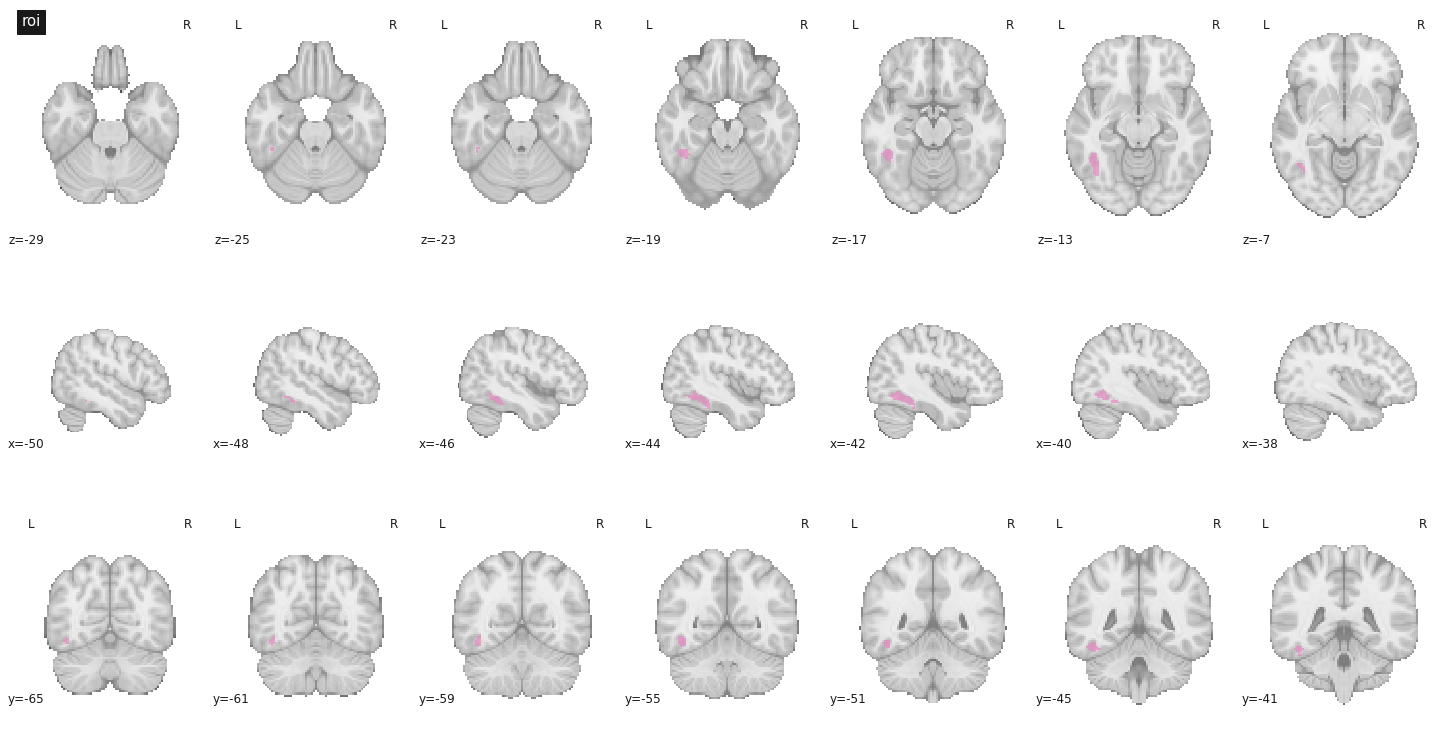

In [11]:
region_names = [label for label in ['L S_oc-temp_lat']]
mask = np.isin(atlas_map, [label_to_id_dict[label] for label in region_names])
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plotting.plot_roi(test_mask_img, title="roi", figure=plt.figure(figsize=(20,10)), display_mode='mosaic', cmap=cmap)

In [5]:
# SUBJECT = "sub-01"
# fmri_data_dir = os.path.join(TWO_STAGE_GLM_DATA_DIR, SUBJECT)
# gray_matter_mask_address = os.path.join(fmri_data_dir, f'unstructured', 'mask.nii')
# gray_matter_mask_img = nib.load(gray_matter_mask_address)
# gray_matter_mask_ras = nib.as_closest_canonical(gray_matter_mask_img)

# # atlas_hcp = nib.load(os.path.join(ROOT_DIR, 'atlas_data/MNI_Glasser_HCP_v1.0.nii.gz'))
# # hcp_resampled = resample_to_img(atlas_hcp, ref_img, interpolation='nearest')
# # hcp_data = hcp_resampled.get_fdata().round().astype(np.int32)

# mask = get_functional_mask(MASK_FUNCTIONAL_VISUAL1, gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="visual1", figure=fig)

# mask = get_functional_mask(MASK_FUNCTIONAL_VISUAL2, gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="visual2", figure=fig)

# mask = get_functional_mask(MASK_FUNCTIONAL_LANGUAGE, gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="language", figure=fig)

# mask = get_functional_mask("functional_Dorsal-Attention", gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="Dorsal-Attention", figure=fig)

# mask = get_functional_mask("functional_Ventral-Multimodal", gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="Ventral-Multimodal", figure=fig)

# mask = get_functional_mask("functional_Posterior-Multimodal", gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="Ventral-Multimodal", figure=fig)


# mask = get_functional_mask("functional_Visual1_Visual2", gray_matter_mask_ras)
# test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
# fig = plt.figure(figsize=(10,5))
# fig = plotting.plot_roi(test_mask_img, title="V1V2", figure=fig)


2301


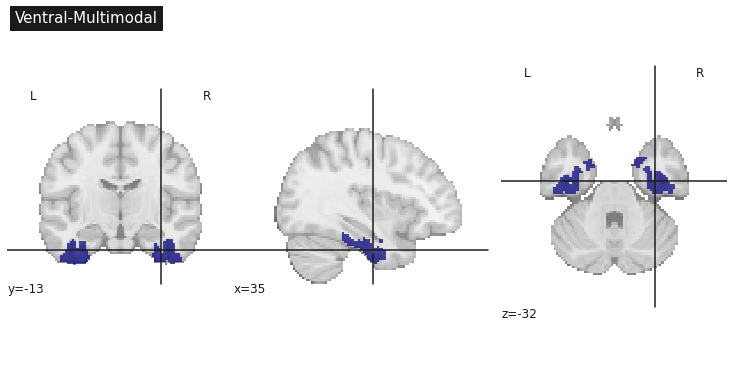

In [6]:
name = "functional_Ventral-Multimodal"
mask = get_functional_mask(name, gray_matter_mask_ras)
print(mask.sum())
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plt.figure(figsize=(10,5))
fig = plotting.plot_roi(test_mask_img, title=name.split("_")[1], figure=fig)


27347


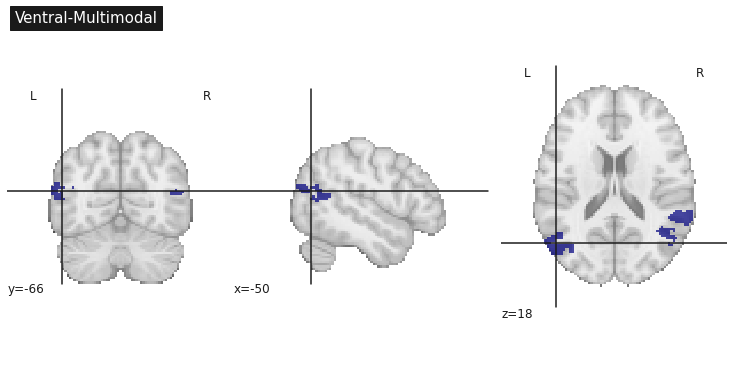

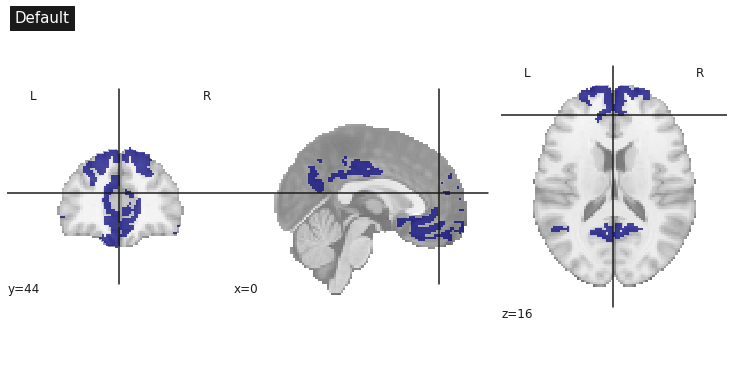

In [7]:
mask = get_functional_mask("functional_Posterior-Multimodal", gray_matter_mask_ras)
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plt.figure(figsize=(10,5))
fig = plotting.plot_roi(test_mask_img, title="Ventral-Multimodal", figure=fig)

name = "functional_Default"
mask = get_functional_mask(name, gray_matter_mask_ras)
print(mask.sum())
test_mask_img = Nifti1Image(mask*1.0, affine=gray_matter_mask_ras.affine)
fig = plt.figure(figsize=(10,5))
fig = plotting.plot_roi(test_mask_img, title=name.split("_")[1], figure=fig)